pip install biosignalsnotebooks

pip install neurokit2

In [1]:
import numpy as np
import pandas as pd
import biosignalsnotebooks as bsnb
import neurokit2 as nk
from scipy import signal
from matplotlib import pyplot as plt

# wavelets
import pywt
from pywt import swt, iswt, wavedec, waverec # package on Wavelet decomposition algorithms
from skimage.restoration import denoise_wavelet
from copy import deepcopy

# data pull
import sys
import biosignal_processing_package as rndSignal
repo = '/root/repos/biosignal_processing_package/'
sys.path.insert(1, repo)

In [2]:
# temporary function for plotting signals
def plot_signal(clean_signal, label = None):
    t = np.linspace(0, len(clean_signal), len(clean_signal))
    plt.plot(t, clean_signal, label = label)
    plt.legend(title="window length")

In [3]:
# # import data (expanded pilot data)
# sig = pd.read_csv(repo+'data/signal.csv')

# participants = sig.player.unique()
# participant1 = participants[0]
# participant2 = participants[1]
# participant3 = participants[2]

# p1_signal = sig[sig.player == participant1]
# p2_signal = sig[sig.player == participant2]
# p3_signal = sig[sig.player == participant3]

# simulate data
# regular ppg signal
p1_signal = nk.ppg_simulate(
            duration = 120,
            sampling_rate = 1000,
            heart_rate = 60)
# Noisy ppg signal
p2_signal = nk.ppg_simulate(
            duration = 120,
            sampling_rate = 1000,
            heart_rate = 60,
            ibi_randomness = 0.5,
            drift = 0.5,
            motion_amplitude = 0.8,
            powerline_amplitude = 0.1,
            burst_amplitude = 0.4)
# regular ecg signal
p1_signal_ecg = nk.ecg_simulate(
            duration = 120,
            sampling_rate = 1000,
            heart_rate = 60)
# Noisy ecg signal
p2_signal_ecg = nk.ecg_simulate(
            duration = 120,
            sampling_rate = 1000,
            heart_rate = 60,
            noise = 0.5)

# Stationary Wavelet Transform (SWT on PPG)

In [4]:
def wavelet_denoise_swt(sig, wavelet="db4", level=7): # default settings for PPG
    """
    Denoises signals with stationary wavelet transform, thresholding, and signal reconstruction.
    Default parameters are recommended defaults for PPG processing.
    
    Credits to BiosignalsPLUX for their SWT code (https://biosignalsplux.com/learn/notebooks/Categories/Other/bvp_analysis_rev.php)
    
    ----------
    Parameters
    ----------
    sig (array-like) - signal
    wavelet (string) - the mother wavelet to use
    level (int) - the number of wavelet decomposition levels to use

    ----------
    Returns
    ----------
    rec_signal (array-like) - denoised signal
    """
        
    # pad to ensure that the number of signal samples is a power of 2.
    sig_length = len(sig)
    sig = np.pad(sig, (0, 2**int(np.ceil(np.log2(len(sig)))) - len(sig)), "constant")

    # applying SWT
    swt_orig_coeffs = swt(sig, wavelet=wavelet, level=level)
    swt_coeffs_copy = deepcopy(swt_orig_coeffs)

    # calculating thresholds per level
    for lvl in range(0, level):
        thr_avg_dt = np.mean(swt_orig_coeffs[lvl][1])
        thr_avg_sc_low = np.mean(swt_orig_coeffs[lvl][0]) - 3 * np.std(swt_orig_coeffs[lvl][0])
        thr_avg_sc_high = np.mean(swt_orig_coeffs[lvl][0]) + 3 * np.std(swt_orig_coeffs[lvl][0])

        # applying calculated thresholds to coefficients
        for coeff_nbr in range(0, len(swt_orig_coeffs[lvl][1])):
            if swt_orig_coeffs[lvl][1][coeff_nbr] > thr_avg_dt: # Motion artifact coefficients.
                swt_orig_coeffs[lvl][1][coeff_nbr] = 0

            if swt_orig_coeffs[lvl][0][coeff_nbr] < thr_avg_sc_low or swt_orig_coeffs[lvl][0][coeff_nbr] > thr_avg_sc_high: # Motion artifact coefficients.
                swt_orig_coeffs[lvl][0][coeff_nbr] = 0
            else: # Storage of noise artifact coefficients in a separate list.
                swt_coeffs_copy[lvl][0][coeff_nbr] = 0
    
    # reconstructing the signal with thresholded coefficients
    rec_signal = iswt(swt_orig_coeffs, wavelet=wavelet)
    
    return rec_signal[:sig_length]

CPU times: user 541 ms, sys: 7.89 ms, total: 549 ms
Wall time: 548 ms


0.035155182739321195

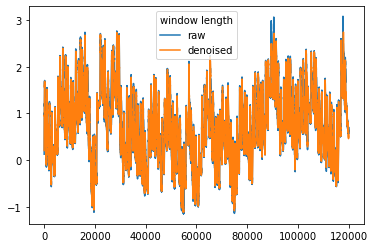

In [5]:
%%time
denoised_ppg = wavelet_denoise_swt(p2_signal)
plot_signal(p2_signal, "raw")
plot_signal(denoised_ppg, "denoised")

np.mean(abs(p2_signal-denoised_ppg)) # difference between

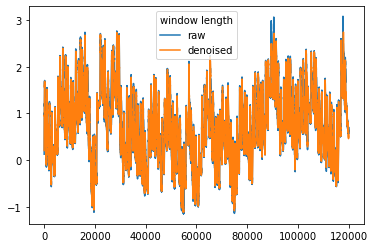

In [6]:
# comparing signal raw and denoised
denoised_ppg = wavelet_denoise_swt(p2_signal)
plot_signal(p2_signal, "raw")
plot_signal(denoised_ppg, "denoised")

# on entire signal

# Discrete Wavelet Transform (DWT on ECG)

In [7]:
def wavelet_denoise_dwt(sig, wavelet="db4", level=8, mode="hard"): # default settings for ECG
    """
    Wrapper function for scikit-image's denoise_wavelet function with recommended defaults for ECG preprocessing.
    Applies discrete wavelet transform (DWT) to denoise signals.
    
    ----------
    Parameters
    ----------
    sig (array-like) - signal
    wavelet (string) - the mother wavelet to use
    level (int) - the number of wavelet decomposition levels to use
    mode (string) - the type of thresholding to use

    ----------
    Returns
    ----------
    denoised (array-like) - denoised signal
    """
    sig_length = len(sig)
    
    # pad to ensure that the number of signal samples is a power of 2.
    sig = np.pad(sig, (0, 2**int(np.ceil(np.log2(len(sig)))) - len(sig)), "constant")
    
    denoised = denoise_wavelet(sig, wavelet=wavelet, mode=mode, wavelet_levels=level)
    
    return denoised[:sig_length]

In [8]:
%%time
denoised_ecg = wavelet_denoise_dwt(p2_signal_ecg)

CPU times: user 4.66 ms, sys: 1.01 ms, total: 5.67 ms
Wall time: 4.93 ms


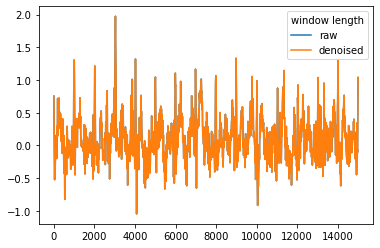

In [9]:
# comparing signal raw and denoised
plot_signal(p2_signal_ecg[:15000], "raw")
plot_signal(denoised_ecg[:15000], "denoised")

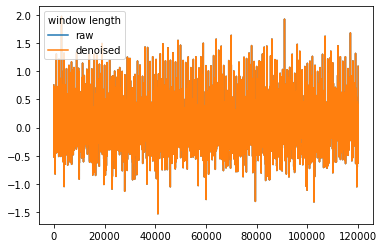

In [10]:
# comparing signal raw and denoised
denoised_ecg = wavelet_denoise_dwt(p2_signal_ecg)
plot_signal(p2_signal_ecg, "raw")
plot_signal(denoised_ecg, "denoised")

# on entire signal

wavelet functions as currently constructed are not too effective with simulated data